# Objectif :
Améliorer le temps, le coût et la qualité de l’embauche dans le cadre d’un recrutement aléatoire. L’objectif est de minimiser le
temps et le coût de l’embauche et de maximiser la qualité de l’embauche. Vous
pouvez mettre en pratique ici les méthodes d’ANOVA, de corrélation et de régression linéaire multiple afin d’effectuer l’analyse prédictive avec cet ensemble de
données.

# Plan 
- (a) Présentation du problème et des objectifs de l’étude ;
- (b) Présentation des données, description rapide des données (nombre d’observations,
de variables, présence ou non de données manquantes, statistiques descriptives univariées et bivariées, etc.) ;
- (c) Préparation des données (recodages, normalisations, etc.) ;
- (d) Définition et estimation du modèle explicatif et/ou prédictif à partir des données ;
- (e) Évaluation, diagnostic et vérification de la qualité du modèle et affinage ;
- (f) Interprétation, bilan et conclusion.

In [2]:
# Importation des Packages.
import pandas as pd
#import skimpy
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import scipy
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.stats.descriptivestats as ds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OrdinalEncoder
import itertools
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# Chargement de nos données.
df = pd.read_csv('Time-Cost-Quality of Hire.csv', 
                 sep=';')

**Preparation des données (recodages, normalisations, ect)**

In [4]:
# Groupes de Variables 
var_quant = df.select_dtypes(include= 'int').columns
var_date = ['Job Open Date', 'Hire Date']
var_quali = ['Department', 'Job Title', 'Source of Hire', 'Type of Hire', 'PerformanceScore', 'Sex']

In [5]:
for i in var_quali :
    for j in var_quali: 
        if i == j : 
            print(f" On traite les mêmes variables. Ici {i}")
        else : 
            crosstab_quali = pd.crosstab(df[i], df[j])
            corr_quali = scipy.stats.chi2_contingency(crosstab_quali)
            print(f'La correlation entre {i} et {j} on a une statistique de {corr_quali.statistic} avec p-value {round(corr_quali.pvalue,3)}')

 On traite les mêmes variables. Ici Department
La correlation entre Department et Job Title on a une statistique de 192.0 avec p-value 0.0
La correlation entre Department et Source of Hire on a une statistique de 31.336347872482328 avec p-value 0.002
La correlation entre Department et Type of Hire on a une statistique de 7.537206186822555 avec p-value 0.057
La correlation entre Department et PerformanceScore on a une statistique de 5.472009093492469 avec p-value 0.791
La correlation entre Department et Sex on a une statistique de 2.75857789269554 avec p-value 0.43
La correlation entre Job Title et Department on a une statistique de 192.0 avec p-value 0.0
 On traite les mêmes variables. Ici Job Title
La correlation entre Job Title et Source of Hire on a une statistique de 43.906507936507936 avec p-value 0.008
La correlation entre Job Title et Type of Hire on a une statistique de 8.255072463768116 avec p-value 0.22
La correlation entre Job Title et PerformanceScore on a une statistique d

test de shapiro (test pour voir si la valeurs des variables est normale)

In [6]:
w_values = [] 
for i in var_quant: 
    norm_fit_base = stats.shapiro(df[i])
    w_values.append(norm_fit_base.statistic) 
    print(f'La variable {i} a un W de {norm_fit_base.statistic}') 
sum_w = sum(w_values)
print(f"\nSomme des W pour la transformation en Scaled : {sum_w:.4f}") 

La variable Sl. No a un W de 0.955129086971283
La variable Fiscal Year a un W de 1.0
La variable Quarter a un W de 0.861521303653717
La variable Yearly PayScale (Yen) a un W de 0.9627292156219482
La variable Cost of Hire a un W de 0.48804473876953125
La variable Time to Hire (Days) a un W de 0.7928891777992249
La variable Quality of Hire a un W de 0.7022024989128113
La variable Engagement a un W de 0.8463815450668335
La variable Ramp Up Time a un W de 0.866502046585083
La variable Culture Fit (%) a un W de 0.6224709749221802

Somme des W pour la transformation en Scaled : 8.0979


c:\Users\ghali\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


on va essayer de normaliser la donnée avec differente librairie

on decide de standariser car standariser conserve les distributions gaussiennes (normales) et respecte les outliers et elle est robuste pour les analyses statistiques, notamment les test paramétriques comme l'ANOVA ou la régression linéaire. 

Alors que normaliser la donnée est utile pour les réseaux de neurones et les algorithmes basés sur des distances (KNN, SVM et clustering)

Nous avons decidé d'utiliser StandardScaler() car les variables ont des échelles différentes (ex : coût en monnaie et Culture Fit en %).

In [7]:
df.head()

,Sl. No,Fiscal Year,Quarter,Department,Job Open Date,Hire Date,Job Title,Source of Hire,Type of Hire,PerformanceScore,Sex,Yearly PayScale (Yen),Cost of Hire,Time to Hire (Days),Quality of Hire,Engagement,Ramp Up Time,Culture Fit (%)
0,1,2018,1,Production,04/01/2018,03/02/2018,Production Technician I,Job Boards,External,Fully Meets,F,744000,2625,30,41,45,95,47
1,2,2018,1,Production,05/01/2018,02/02/2018,Production Technician I,Agency,External,Fully Meets,F,744000,89280,28,41,82,95,47
2,3,2018,1,Production,04/02/2018,05/04/2018,Production Technician I,LinkedIn,External,Exceeds,F,660000,4000,60,41,26,85,48
3,4,2018,1,IT,04/02/2018,03/03/2018,Software Engineer,Agency,External,Fully Meets,F,960000,115200,27,41,28,85,48
4,5,2018,1,Production,04/02/2018,04/03/2018,Production Technician I,Career Portal,External,Fully Meets,M,660000,10000,28,41,34,93,51


StandardScaler()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Sl. No                 64 non-null     int64 
 1   Fiscal Year            64 non-null     int64 
 2   Quarter                64 non-null     int64 
 3   Department             64 non-null     object
 4   Job Open Date          64 non-null     object
 5   Hire Date              64 non-null     object
 6   Job Title              64 non-null     object
 7   Source of Hire         64 non-null     object
 8   Type of Hire           64 non-null     object
 9   PerformanceScore       64 non-null     object
 10  Sex                    64 non-null     object
 11  Yearly PayScale (Yen)  64 non-null     int64 
 12  Cost of Hire           64 non-null     int64 
 13  Time to Hire (Days)    64 non-null     int64 
 14  Quality of Hire        64 non-null     int64 
 15  Engagement             64

In [9]:
df.min()


Sl. No                                      1
Fiscal Year                              2018
Quarter                                     1
Department                                 IT
Job Open Date                      01/04/2018
Hire Date                          01/02/2019
Job Title                IT Manager - Support
Source of Hire                         Agency
Type of Hire                         External
PerformanceScore                      Exceeds
Sex                                         F
Yearly PayScale (Yen)                  168000
Cost of Hire                             2625
Time to Hire (Days)                        20
Quality of Hire                            41
Engagement                                 26
Ramp Up Time                               24
Culture Fit (%)                            47
dtype: object

In [ ]:
# Box-Cox : lorsque les données sont asymétriques et que tu veux les rendre normales pour des modèles comme la régression linéaire.
from sklearn.preprocessing import PowerTransformer


vars_to_transform = ["Cost of Hire", "Time to Hire (Days)", "Quality of Hire", "Engagement", "Culture Fit (%)"]

df_scaled = df.copy()

pt = PowerTransformer(method='box-cox', standardize=True)

df_scaled[vars_to_transform] = pt.fit_transform(df_scaled[vars_to_transform])
df_scaled =  pd.DataFrame(df_scaled, columns = vars_to_transform)
df_scaled.head()


w_values = [] 
for i in vars_to_transform: 
    norm_fit_scaled = stats.shapiro(df_scaled[i])
    w_values.append(norm_fit_scaled.statistic) 
    print(f'La variable {i} a un W de {norm_fit_scaled.statistic}') 
sum_w = sum(w_values)
print(f"\nSomme des W pour la transformation en Scaled : {sum_w:.4f}")

La variable Cost of Hire a un W de 0.8604899644851685
La variable Time to Hire (Days) a un W de 0.9433550834655762
La variable Quality of Hire a un W de 0.8539652228355408
La variable Engagement a un W de 0.9302398562431335
La variable Culture Fit (%) a un W de 0.8125029802322388

Somme des W pour la transformation en Scaled : 4.4006


In [11]:
df_remaining = df.drop(columns = vars_to_transform)
df_standardized = pd.concat([df_remaining, df_scaled], axis = 1)
df_standardized.head()

,Sl. No,Fiscal Year,Quarter,Department,Job Open Date,Hire Date,Job Title,Source of Hire,Type of Hire,PerformanceScore,Sex,Yearly PayScale (Yen),Ramp Up Time,Cost of Hire,Time to Hire (Days),Quality of Hire,Engagement,Culture Fit (%)
0,1,2018,1,Production,04/01/2018,03/02/2018,Production Technician I,Job Boards,External,Fully Meets,F,744000,95,-1.273902,-0.212236,-1.866466,0.095856,-2.091232
1,2,2018,1,Production,05/01/2018,02/02/2018,Production Technician I,Agency,External,Fully Meets,F,744000,95,1.756976,-0.496487,-1.866466,1.349504,-2.091232
2,3,2018,1,Production,04/02/2018,05/04/2018,Production Technician I,LinkedIn,External,Exceeds,F,660000,85,-0.542236,1.641192,-1.866466,-1.719208,-2.082274
3,4,2018,1,IT,04/02/2018,03/03/2018,Software Engineer,Agency,External,Fully Meets,F,960000,85,1.823602,-0.656151,-1.866466,-1.424868,-2.082274
4,5,2018,1,Production,04/02/2018,04/03/2018,Production Technician I,Career Portal,External,Fully Meets,M,660000,93,0.569074,-0.496487,-1.866466,-0.731898,-2.049459


In [12]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sl. No                 64 non-null     int64  
 1   Fiscal Year            64 non-null     int64  
 2   Quarter                64 non-null     int64  
 3   Department             64 non-null     object 
 4   Job Open Date          64 non-null     object 
 5   Hire Date              64 non-null     object 
 6   Job Title              64 non-null     object 
 7   Source of Hire         64 non-null     object 
 8   Type of Hire           64 non-null     object 
 9   PerformanceScore       64 non-null     object 
 10  Sex                    64 non-null     object 
 11  Yearly PayScale (Yen)  64 non-null     int64  
 12  Ramp Up Time           64 non-null     int64  
 13  Cost of Hire           64 non-null     float64
 14  Time to Hire (Days)    64 non-null     float64
 15  Quality 

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_cols = df_standardized.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
df_standardized[numerical_cols] = scaler.fit_transform(df_standardized[numerical_cols])

df_standardized.head()


,Sl. No,Fiscal Year,Quarter,Department,Job Open Date,Hire Date,Job Title,Source of Hire,Type of Hire,PerformanceScore,Sex,Yearly PayScale (Yen),Ramp Up Time,Cost of Hire,Time to Hire (Days),Quality of Hire,Engagement,Culture Fit (%)
0,-1.705196,0.0,-1.612913,Production,04/01/2018,03/02/2018,Production Technician I,Job Boards,External,Fully Meets,F,1.227128,0.798634,-1.273902,-0.212236,-1.866466,0.095856,-2.091232
1,-1.651062,0.0,-1.612913,Production,05/01/2018,02/02/2018,Production Technician I,Agency,External,Fully Meets,F,1.227128,0.798634,1.756976,-0.496487,-1.866466,1.349504,-2.091232
2,-1.596929,0.0,-1.612913,Production,04/02/2018,05/04/2018,Production Technician I,LinkedIn,External,Exceeds,F,0.818984,0.359523,-0.542236,1.641192,-1.866466,-1.719208,-2.082274
3,-1.542796,0.0,-1.612913,IT,04/02/2018,03/03/2018,Software Engineer,Agency,External,Fully Meets,F,2.276640,0.359523,1.823602,-0.656151,-1.866466,-1.424868,-2.082274
4,-1.488663,0.0,-1.612913,Production,04/02/2018,04/03/2018,Production Technician I,Career Portal,External,Fully Meets,M,0.818984,0.710812,0.569074,-0.496487,-1.866466,-0.731898,-2.049459


On va à present Encoder les variables catégorielles

In [14]:
var_quali_encoded = ['Department', 'Job Title', 'Source of Hire', 'Type of Hire']

df_standardized = pd.get_dummies(df_standardized, columns =var_quali_encoded, drop_first=True)
print(df_standardized.columns)

df_standardized['PerformanceScore'] = df_standardized['PerformanceScore'].astype('object')

ordinal_cat = [['PIP','Needs Improvement','Fully Meets','Exceeds']]
encoder = OrdinalEncoder(categories= ordinal_cat)
df_standardized['PerformanceScore'] = encoder.fit_transform(df_standardized[['PerformanceScore']])

encoder = LabelEncoder()
df_standardized['Sex']= encoder.fit_transform(df_standardized['Sex'])



Index(['Sl. No', 'Fiscal Year', 'Quarter', 'Job Open Date', 'Hire Date',
       'PerformanceScore', 'Sex', 'Yearly PayScale (Yen)', 'Ramp Up Time',
       'Cost of Hire', 'Time to Hire (Days)', 'Quality of Hire', 'Engagement',
       'Culture Fit (%)', 'Department_Marketing', 'Department_Production',
       'Department_Sales', 'Job Title_Marketing Analyst',
       'Job Title_Production Manager', 'Job Title_Production Technician I',
       'Job Title_Software Engineer', 'Job Title_Sr. Network Engineer',
       'Job Title_Sr. Sales Engineer', 'Source of Hire_Career Portal',
       'Source of Hire_Employee Referral', 'Source of Hire_Job Boards',
       'Source of Hire_LinkedIn', 'Type of Hire_Internal'],
      dtype='object')


In [15]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Sl. No                             64 non-null     float64
 1   Fiscal Year                        64 non-null     float64
 2   Quarter                            64 non-null     float64
 3   Job Open Date                      64 non-null     object 
 4   Hire Date                          64 non-null     object 
 5   PerformanceScore                   64 non-null     float64
 6   Sex                                64 non-null     int32  
 7   Yearly PayScale (Yen)              64 non-null     float64
 8   Ramp Up Time                       64 non-null     float64
 9   Cost of Hire                       64 non-null     float64
 10  Time to Hire (Days)                64 non-null     float64
 11  Quality of Hire                    64 non-null     float64
 

In [16]:
cols_to_bool = ["PerformanceScore", "Sex"]
df_standardized[cols_to_bool] = df_standardized[cols_to_bool].astype(bool)

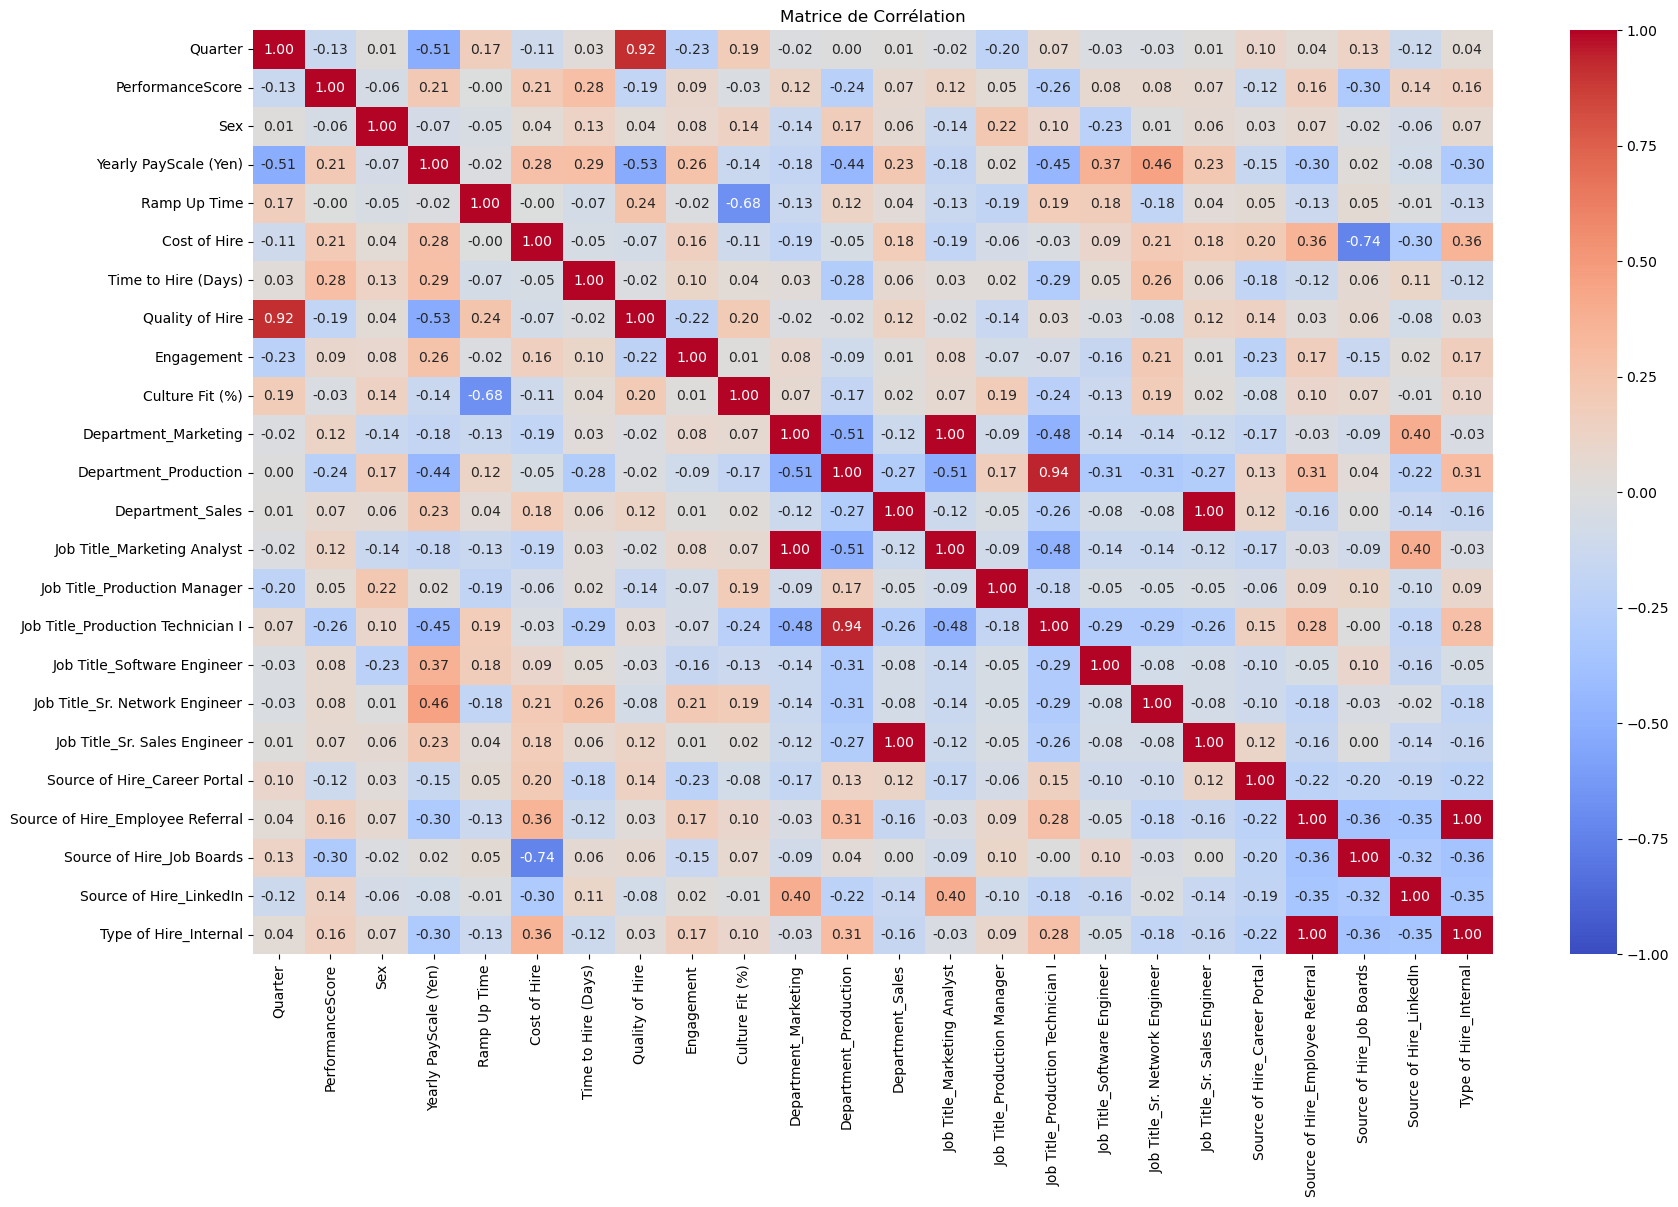

In [17]:
var_date = ['Job Open Date', 'Hire Date','Sl. No']

var_date.append('Fiscal Year')

df_standardized = df_standardized.drop(columns = var_date)
corr_matrix = df_standardized.corr()

df_standardized = df_standardized.applymap(lambda x : 1 if x is True else (0 if x is False else x))

# Pas de changement dans Matrice de Correlation si Avant ou Après.

plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot = True , cmap = 'coolwarm', 
            fmt='.2f',vmin = -1,vmax =1)
plt.title("Matrice de Corrélation")
plt.show()
#Fiscal Year : les éléments d'une colonne ont la même valeur,
#  la corrélation ne peut pas être calculée

Pour analyser les corrélations dans ton correlogramme :

**1.Variables explicatives corrélées entre elles**

- Yearly PayScale (Yen)" et "Cost of Hire" ont une forte corrélation positive (0.62).
- Engagement et Quality of Hire sont aussi bien corrélés (0.84).
- Quarter" et Sl. No. sont quasi parfaitement corrélés (0.96), probablement parce que Sl. No. est un identifiant séquentiel.
- Department_Marketing et Job_Title_Marketing Analyst (1)
- Department_Sales et Job_Title_Sr. Sales Engineer (1)
- Source_of_Hire_Employee Referral et Type_of_Hire_Internal (1)


**2.Corrélations avec les variables cibles :**
 
   - Cost of Hire :
     - Fortement corrélée avec "Yearly PayScale (Yen)" (0.62), ce qui est logique.
     - Modérément corrélée avec "Culture Fit (%)" (0.26).

   - Quality of Hire:
     - Très corrélée avec "Culture Fit (%)" (0.73) et "Engagement" (0.84) et Quarter (0.91) ce qui suggère que ces variables influencent fortement la qualité des recrutements.

   - Time to Hire (Days) :
     - Peu de corrélations marquées, mais on voit des liens modérés avec "Performance Score" (0.27) et "Quarter" (0.30).
     
On peut voir que des catégories sont corrélées presque a 1 commme job title production avec departmenent production ce qui est normale.

Pour que la variable ait un impact entre la variable cible et la variable explicative, il faut qu'il y ait une corrélation entre 0,3 à 0,7.



In [18]:
df = df.drop(columns=['Sl. No'])

Nous pouvons voir que la variable Job Title et Department ont de forte corrélation entre certaines catégories comme Department_Sales et Job_Ttile8Sr. Sale Engineer, Department_Production et Job_Title_Production Technician

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

vif_data = pd.DataFrame()
vif_data["Variable"] = df_standardized.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_standardized.values, i) if np.linalg.det(np.corrcoef(df_standardized.values.T)) != 0 else np.inf
    for i in range(df_standardized.shape[1])
]

print(vif_data)

                             Variable        VIF
0                             Quarter   8.602893
1                    PerformanceScore  24.292287
2                                 Sex   2.025725
3               Yearly PayScale (Yen)   6.319869
4                        Ramp Up Time   3.232301
5                        Cost of Hire  20.016045
6                 Time to Hire (Days)   1.426289
7                     Quality of Hire  10.955876
8                          Engagement   1.438849
9                     Culture Fit (%)   3.136861
10               Department_Marketing        inf
11              Department_Production        inf
12                   Department_Sales        inf
13        Job Title_Marketing Analyst        inf
14       Job Title_Production Manager        inf
15  Job Title_Production Technician I        inf
16        Job Title_Software Engineer   3.118154
17     Job Title_Sr. Network Engineer   3.017097
18       Job Title_Sr. Sales Engineer        inf
19       Source of H

c:\Users\ghali\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


**A FAIRE ATTENTION** :

- Cost of Hire 16.528336
- Quality of Hire 11.006507
- Source of Hire_Job Boards 28.403847
- Source of Hire_LinkedIn 16.473813

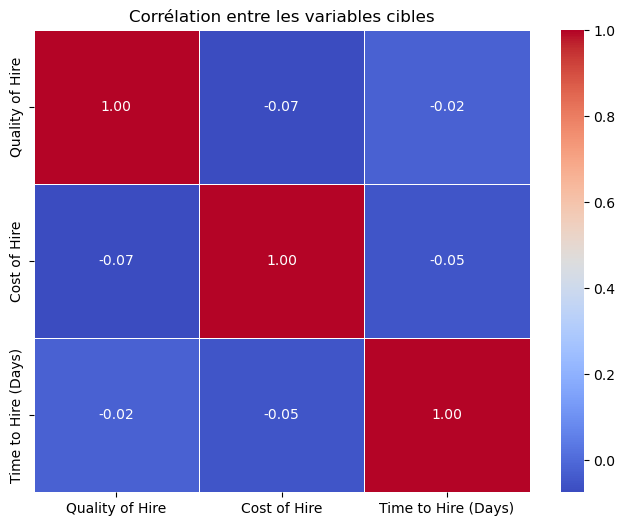

c:\Users\ghali\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


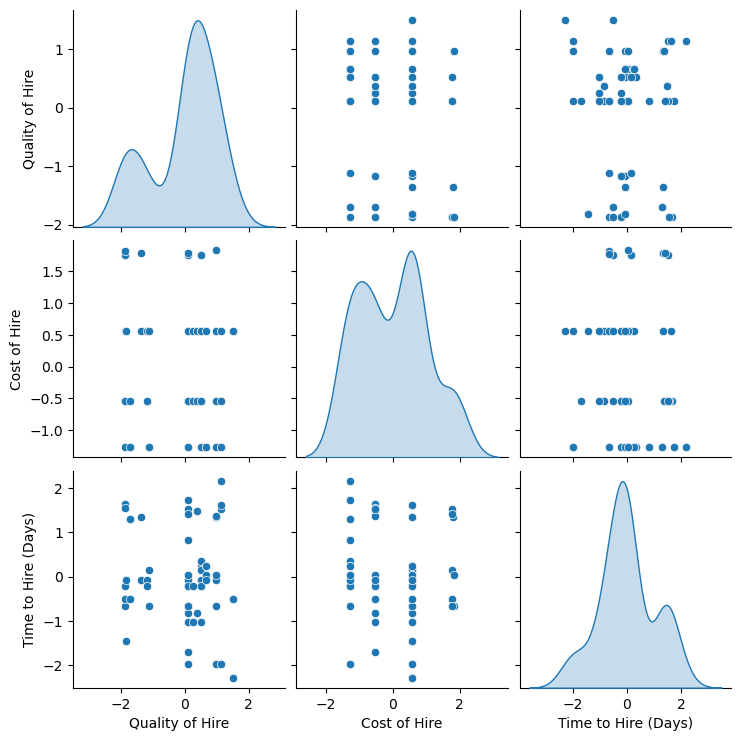

In [ ]:
target_vars = ["Quality of Hire", "Cost of Hire", "Time to Hire (Days)"]

corr_matrix = df_standardized[target_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Corrélation entre les variables cibles")
plt.show()

sns.pairplot(df_standardized[target_vars], diag_kind="kde")
plt.show()

on observe aucune forte corrélation entre les variables cibles

In [21]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Quarter                            64 non-null     float64
 1   PerformanceScore                   64 non-null     int64  
 2   Sex                                64 non-null     int64  
 3   Yearly PayScale (Yen)              64 non-null     float64
 4   Ramp Up Time                       64 non-null     float64
 5   Cost of Hire                       64 non-null     float64
 6   Time to Hire (Days)                64 non-null     float64
 7   Quality of Hire                    64 non-null     float64
 8   Engagement                         64 non-null     float64
 9   Culture Fit (%)                    64 non-null     float64
 10  Department_Marketing               64 non-null     int64  
 11  Department_Production              64 non-null     int64  
 

test ANOVA

In [22]:
df_standardized = df_standardized.rename(columns=lambda x: x.strip().replace(" ","_").replace("(","").replace(")","").replace("%","").replace(".",""))

In [23]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Quarter                            64 non-null     float64
 1   PerformanceScore                   64 non-null     int64  
 2   Sex                                64 non-null     int64  
 3   Yearly_PayScale_Yen                64 non-null     float64
 4   Ramp_Up_Time                       64 non-null     float64
 5   Cost_of_Hire                       64 non-null     float64
 6   Time_to_Hire_Days                  64 non-null     float64
 7   Quality_of_Hire                    64 non-null     float64
 8   Engagement                         64 non-null     float64
 9   Culture_Fit_                       64 non-null     float64
 10  Department_Marketing               64 non-null     int64  
 11  Department_Production              64 non-null     int64  
 

**Test ANOVA pour la variable Time to Hire Days**

In [24]:
var_quali_renamed =  [
    "PerformanceScore", "Sex", "Department_Marketing", "Department_Production", "Department_Sales",
    "Job_Title_Marketing_Analyst", "Job_Title_Production_Manager", "Job_Title_Production_Technician_I",
    "Job_Title_Software_Engineer", "Job_Title_Sr_Network_Engineer", "Job_Title_Sr_Sales_Engineer",
    "Source_of_Hire_Career_Portal", "Source_of_Hire_Employee_Referral", "Source_of_Hire_Job_Boards",
    "Source_of_Hire_LinkedIn", "Type_of_Hire_Internal"
]
target_days = 'Time_to_Hire_Days'
print("ANOVA à 1 facteur :")
for var in var_quali_renamed:
    print(f"\nEffet de {var} sur {target_days} :")
    formula = f"{target_days} ~ C({var})"
    model = smf.ols(formula=formula, data=df_standardized).fit()
    anova_results = anova_lm(model)
    print(anova_results)

ANOVA à 1 facteur :

Effet de PerformanceScore sur Time_to_Hire_Days :
                       df     sum_sq   mean_sq         F    PR(>F)
C(PerformanceScore)   1.0   5.190784  5.190784  5.472417  0.022556
Residual             62.0  58.809216  0.948536       NaN       NaN

Effet de Sex sur Time_to_Hire_Days :
            df     sum_sq   mean_sq         F    PR(>F)
C(Sex)     1.0   1.125092  1.125092  1.109436  0.296292
Residual  62.0  62.874908  1.014111       NaN       NaN

Effet de Department_Marketing sur Time_to_Hire_Days :
                           df     sum_sq   mean_sq         F    PR(>F)
C(Department_Marketing)   1.0   0.041902  0.041902  0.040619  0.840934
Residual                 62.0  63.958098  1.031582       NaN       NaN

Effet de Department_Production sur Time_to_Hire_Days :
                            df     sum_sq   mean_sq         F    PR(>F)
C(Department_Production)   1.0   4.998406  4.998406  5.252421  0.025325
Residual                  62.0  59.001594  0.951639   

**Les variables qui sont significatifs pour Time_to_Hire_Days:**
- PerformancesScore (p-value: 0.022556) 
- Department_Production (p-value: 0.025325)
- Job_Title_Production_Technician_I  (p-value: 0.021247) : une différence significative pour ce titre de poste par rapport aux autres.
- Job_Title_Sr_Network_Engineer (p-value: 0.035525) : il existe une différence pour ce titre de poste par rapport aux autres.

In [25]:
print("\n\nANOVA à 2 facteurs (avec interactions) :")
for var1, var2 in itertools.combinations(var_quali_renamed, 2):
    print(f"\nEffet de {var1}, {var2} et leur interaction sur {target_days} :")
    formula = f"{target_days} ~ C({var1}) + C({var2}) + C({var1}):C({var2})"
    model = smf.ols(formula=formula, data=df_standardized).fit()
    anova_results = anova_lm(model)
    print(anova_results)



ANOVA à 2 facteurs (avec interactions) :

Effet de PerformanceScore, Sex et leur interaction sur Time_to_Hire_Days :
                              df     sum_sq   mean_sq         F    PR(>F)
C(PerformanceScore)          1.0   5.190784  5.190784  5.644723  0.020718
C(Sex)                       1.0   1.427028  1.427028  1.551823  0.217709
C(PerformanceScore):C(Sex)   1.0   2.207295  2.207295  2.400325  0.126569
Residual                    60.0  55.174894  0.919582       NaN       NaN

Effet de PerformanceScore, Department_Marketing et leur interaction sur Time_to_Hire_Days :
                                               df     sum_sq   mean_sq  \
C(PerformanceScore)                           1.0   5.190784  5.190784   
C(Department_Marketing)                       1.0   0.006162  0.006162   
C(PerformanceScore):C(Department_Marketing)   1.0   2.596066  2.596066   
Residual                                     61.0  58.803055  0.963985   

                                               

**Interaction pour Time_to_Hire_Days :**

- C(Department_Production) (pvalue :0.047614)
- C(Department_Production) (pvalue: 0.051248)  
- C(Department_Production):C(Job_Title_Production_Manager) (pvalue :0.029302)
- C(Department_Production):C(Job_Title_Production_Technician_I) (pvalue:0.029412) 
- C(Job_Title_Sr_Network_Engineer)  (pvalue: 0.031424)
- C(Department_Sales):C(Source_of_Hire_Job_Boards) (pvalue:0.000044) 
- C(Department_Sales):C(PerformanceScore)  (pvalue: 0.000318)  
- C(Department_Sales):C(Sex)  (pvalue :0.049636)
- (Job_Title_Sr_Sales_Engineer) : C(Source_of_Hire_Job_Boards) (pvalue:0.000044)  
- C(Job_Title_Sr_Sales_Engineer):C(PerformanceScore) (pvalue:0.000318)
- C(Job_Title_Sr_Sales_Engineer):C(Sex)  (pvalue :0.049636)  

**Problème pour la variable Time_to_Hire_Days :** 
on peut voir que departement_production est significative mais je ne met pas cette variable dans conclusion des variables significative car on a deja Job_Title_Production_Technician_I et Job_Title_Production_Manager et ça va créer  de la colinéarité entre les variables.

**CONCLUSION pour les variable significative pour Time_to_Hire_Days**

variable catégorielle : Job_Title_Production_Technician_I, PerformancesScore, Department_Production, Job_Title_Sr_Network_Engineer


**Test ANOVA pour la variable Cost of Hire**

In [26]:
target_days = 'Cost_of_Hire'
print("ANOVA à 1 facteur :")
for var in var_quali_renamed:
    print(f"\nEffet de {var} sur {target_days} :")
    formula = f"{target_days} ~ C({var})"
    model = smf.ols(formula=formula, data=df_standardized).fit()
    anova_results = anova_lm(model)
    print(anova_results)

ANOVA à 1 facteur :

Effet de PerformanceScore sur Cost_of_Hire :
                       df     sum_sq   mean_sq         F   PR(>F)
C(PerformanceScore)   1.0   2.821233  2.821233  2.859103  0.09588
Residual             62.0  61.178767  0.986754       NaN      NaN

Effet de Sex sur Cost_of_Hire :
            df     sum_sq   mean_sq         F    PR(>F)
C(Sex)     1.0   0.098755  0.098755  0.095817  0.757947
Residual  62.0  63.901245  1.030665       NaN       NaN

Effet de Department_Marketing sur Cost_of_Hire :
                           df     sum_sq   mean_sq         F   PR(>F)
C(Department_Marketing)   1.0   2.204579  2.204579  2.211877  0.14202
Residual                 62.0  61.795421  0.996700       NaN      NaN

Effet de Department_Production sur Cost_of_Hire :
                            df     sum_sq   mean_sq         F    PR(>F)
C(Department_Production)   1.0   0.162019  0.162019  0.157354  0.692967
Residual                  62.0  63.837981  1.029645       NaN       NaN

Effet d

In [27]:
df_standardized.columns

Index(['Quarter', 'PerformanceScore', 'Sex', 'Yearly_PayScale_Yen',
       'Ramp_Up_Time', 'Cost_of_Hire', 'Time_to_Hire_Days', 'Quality_of_Hire',
       'Engagement', 'Culture_Fit_', 'Department_Marketing',
       'Department_Production', 'Department_Sales',
       'Job_Title_Marketing_Analyst', 'Job_Title_Production_Manager',
       'Job_Title_Production_Technician_I', 'Job_Title_Software_Engineer',
       'Job_Title_Sr_Network_Engineer', 'Job_Title_Sr_Sales_Engineer',
       'Source_of_Hire_Career_Portal', 'Source_of_Hire_Employee_Referral',
       'Source_of_Hire_Job_Boards', 'Source_of_Hire_LinkedIn',
       'Type_of_Hire_Internal'],
      dtype='object')

In [28]:
target_cost = 'Cost_of_Hire'

print("\n\nANOVA à 2 facteurs (avec interactions) :")
for var1, var2 in itertools.combinations(var_quali_renamed, 2):
    print(f"\nEffet de {var1}, {var2} et leur interaction sur {target_cost} :")
    formula = f"{target_cost} ~ C({var1}) + C({var2}) + C({var1}):C({var2})"
    model = smf.ols(formula=formula, data=df_standardized).fit()
    anova_results = anova_lm(model)
    print(anova_results)



ANOVA à 2 facteurs (avec interactions) :

Effet de PerformanceScore, Sex et leur interaction sur Cost_of_Hire :
                              df     sum_sq   mean_sq         F    PR(>F)
C(PerformanceScore)          1.0   2.821233  2.821233  2.807355  0.099037
C(Sex)                       1.0   0.169882  0.169882  0.169046  0.682426
C(PerformanceScore):C(Sex)   1.0   0.712299  0.712299  0.708795  0.403187
Residual                    60.0  60.296587  1.004943       NaN       NaN

Effet de PerformanceScore, Department_Marketing et leur interaction sur Cost_of_Hire :
                                               df     sum_sq   mean_sq  \
C(PerformanceScore)                           1.0   2.821233  2.821233   
C(Department_Marketing)                       1.0   2.911439  2.911439   
C(PerformanceScore):C(Department_Marketing)   1.0   0.351195  0.351195   
Residual                                     61.0  58.267329  0.955202   

                                                    F    

**Significativité pour Cost_of_Hire** :

Source_of_Hire_Employee_Referral  (p-value : 0.00389)

Source_of_Hire_Job_Boards  (p-value : 4.463879e-12)

Source_of_Hire_LinkedIn ( p-value : 0.016016)

Type_of_Hire_Internal (p-value : 0.00389)


* Test **ANOVA** pour la variable **Quality of Hire**

In [29]:
target_quality = 'Quality_of_Hire'
print("ANOVA à 1 facteur :")
for var in var_quali_renamed:
    print(f"\nEffet de {var} sur {target_quality} :")
    formula = f"{target_quality} ~ C({var})"
    model = smf.ols(formula=formula, data=df_standardized).fit()
    anova_results = anova_lm(model)
    print(anova_results)

ANOVA à 1 facteur :

Effet de PerformanceScore sur Quality_of_Hire :
                       df     sum_sq   mean_sq        F   PR(>F)
C(PerformanceScore)   1.0   2.207517  2.207517  2.21493  0.14175
Residual             62.0  61.792483  0.996653      NaN      NaN

Effet de Sex sur Quality_of_Hire :
            df    sum_sq   mean_sq         F    PR(>F)
C(Sex)     1.0   0.11062  0.110620  0.107348  0.744287
Residual  62.0  63.88938  1.030474       NaN       NaN

Effet de Department_Marketing sur Quality_of_Hire :
                           df     sum_sq   mean_sq         F    PR(>F)
C(Department_Marketing)   1.0   0.029212  0.029212  0.028313  0.866924
Residual                 62.0  63.970788  1.031787       NaN       NaN

Effet de Department_Production sur Quality_of_Hire :
                            df     sum_sq   mean_sq         F   PR(>F)
C(Department_Production)   1.0   0.018882  0.018882  0.018297  0.89284
Residual                  62.0  63.981118  1.031954       NaN      NaN

E

In [30]:
print("\n\nANOVA à 2 facteurs (avec interactions) :")
for var1, var2 in itertools.combinations(var_quali_renamed, 2):
    print(f"\nEffet de {var1}, {var2} et leur interaction sur {target_quality} :")
    formula = f"{target_quality} ~ C({var1}) + C({var2}) + C({var1}):C({var2})"
    model = smf.ols(formula=formula, data=df_standardized).fit()
    anova_results = anova_lm(model)
    print(anova_results)



ANOVA à 2 facteurs (avec interactions) :

Effet de PerformanceScore, Sex et leur interaction sur Quality_of_Hire :
                              df     sum_sq   mean_sq         F    PR(>F)
C(PerformanceScore)          1.0   2.207517  2.207517  2.146096  0.148154
C(Sex)                       1.0   0.061013  0.061013  0.059316  0.808411
C(PerformanceScore):C(Sex)   1.0   0.014288  0.014288  0.013890  0.906575
Residual                    60.0  61.717182  1.028620       NaN       NaN

Effet de PerformanceScore, Department_Marketing et leur interaction sur Quality_of_Hire :
                                               df     sum_sq   mean_sq  \
C(PerformanceScore)                           1.0   2.207517  2.207517   
C(Department_Marketing)                       1.0   0.000182  0.000182   
C(PerformanceScore):C(Department_Marketing)   1.0   2.490670  2.490670   
Residual                                     61.0  61.792302  1.012989   

                                                   

**Conclusion pour Quality_of_Hire** : 
- PerformanceScore et Source_of_Hire_Employee_Referral (p-value: 0.049348)
- PerformanceScore et Source_of_Hire_LinkedIn (p-value: 0.0.035838)
- PerformanceScore et Type_of_Hire_Internal (p-value: 0.049348)
- Job_Title_Marketing_Analyst (p-value: 0.015125)
- Sex et Job_Title_Software_Engineer (p-value: 0.049405)
- Sex et Source_of_Hire_Employee_Referral (p-value: 0.021963)
- Sex et Type_of_Hire_Internal (p-value: 0.021963)
- Department_Marketing et Job_Title_Software_Engineer (p-value: 0.040329)
- Department_Marketing et Source_of_Hire_Employee_Referral (p-value: 0.001289)
- Department_Marketing et Source_of_Hire_LinkedIn (p-value: 0.013593)
- Department_Marketing et Type_of_Hire_Internal (p-value: 0.001289)
- Department_Production et Job_Title_Marketing_Analyst (p-value:0.038880)
- Department_Production et Job_Title_Sr_Network_Engineer (p-value:0.046371)
- Department_Production et Source_of_Hire_Employee_Referral (p-value:0.007534)
- Department_Production et Source_of_Hire_LinkedIn (p-value:0.019488)
- Department_Production et Type_of_Hire_Internal (p-value: 0.007534)


   - Quality of Hire pour variables quantitatives:
     - Très corrélée avec "Culture Fit (%)" (0.73) et "Engagement" (0.84) et Quarter (0.91) ce qui suggère que ces variables influencent fortement la qualité des recrutements.


- Department_Marketing et Source_of_Hire_Employee_Referral (p-value: 0.001289)
- Department_Marketing et Type_of_Hire_Internal (p-value: 0.001289)
- Department_Production et Type_of_Hire_Internal (p-value: 0.007534)
- Department_Production et Source_of_Hire_Employee_Referral (p-value:0.007534)


In [31]:
df_standardized = df_standardized.loc[:, ~df_standardized.columns.duplicated()]

In [32]:
df_standardized = df_standardized.rename(columns=lambda x: x.strip().replace(" ","_").replace("(","").replace(")","").replace("%","").replace(".",""))

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

X = df_standardized.drop(['Cost_of_Hire', 'Time_to_Hire_Days', 'Quality_of_Hire'], axis=1)  # Variables explicatives
y = df_standardized[['Cost_of_Hire', 'Time_to_Hire_Days', 'Quality_of_Hire']]  # Variables cibles

import statsmodels.api as sm

X = sm.add_constant(X)

models = {}
p_values = {}
r_squared = {}

for target in y.columns:
    formula = f"{target} ~ " + " + ".join(X.columns.difference(['const']))
    model = sm.OLS.from_formula(formula, data=X.join(y)).fit()
    models[target] = model
    p_values[target] = model.pvalues
    r_squared[target] = model.rsquared

    print(f"\nP-values pour la régression de {target} :")
    print(model.summary())  


P-values pour la régression de Cost_of_Hire :
                            OLS Regression Results                            
Dep. Variable:           Cost_of_Hire   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.081e+04
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           3.18e-90
Time:                        04:14:59   Log-Likelihood:                 217.07
No. Observations:                  64   AIC:                            -398.1
Df Residuals:                      46   BIC:                            -359.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [34]:
df_standardized.columns

Index(['Quarter', 'PerformanceScore', 'Sex', 'Yearly_PayScale_Yen',
       'Ramp_Up_Time', 'Cost_of_Hire', 'Time_to_Hire_Days', 'Quality_of_Hire',
       'Engagement', 'Culture_Fit_', 'Department_Marketing',
       'Department_Production', 'Department_Sales',
       'Job_Title_Marketing_Analyst', 'Job_Title_Production_Manager',
       'Job_Title_Production_Technician_I', 'Job_Title_Software_Engineer',
       'Job_Title_Sr_Network_Engineer', 'Job_Title_Sr_Sales_Engineer',
       'Source_of_Hire_Career_Portal', 'Source_of_Hire_Employee_Referral',
       'Source_of_Hire_Job_Boards', 'Source_of_Hire_LinkedIn',
       'Type_of_Hire_Internal'],
      dtype='object')

**Pour Cost_Of_Hire les variables significatifs sont** : 

- Source_of_Hire_Career_Portal (p-value : 0.000)
- Source_of_Hire_Employee_Referral (p-value : 0.000)
- Source_of_Hire_Job_Boards (p-value : 0.000)    
- Source_of_Hire_LinkedIn (p-value : 0.000)    
- Type_of_Hire_Internal (p-value : 0.000)   
- Yearly_PayScale_Yen   (p-value : 0.028)
- Engagement  (p-value : 0.027)



**Pour Time_to_Hire_Days les variables significatifs sont aucune** 

**Significativé des variables par test pour Time_to_Hire_Days :**
- PerformancesScore (p-value: 0.022556) 
- Department_Production (p-value: 0.025325)
- Job_Title_Production_Technician_I  (p-value: 0.021247) 
- Job_Title_Sr_Network_Engineer (p-value: 0.035525) 

- **variables quantitatives par corrélation :**

- Performance Score (0.27) et Quarter (0.30)


**Pour Quality_of_Hire les variables significatifs** : 
- Culture_Fit_  (p-value: 0.014)
- Department_Sales    (p-value: 0.042)   
- Job_Title_Sr_Sales_Engineer  (p-value: 0.042)    
- PerformanceScore   (p-valu: 0.062)     
- Quarter    (p-value :0.000)   
- Ramp_Up_Time    (p-value :0.002)     
- Yearly_PayScale_Yen  (p-value :0.040) 



In [ ]:
##### COST_OF_HIRE ########
import statsmodels.api as sm

X = df_standardized[['Source_of_Hire_Career_Portal', 'Source_of_Hire_Employee_Referral', 'Source_of_Hire_Job_Boards',  'Source_of_Hire_LinkedIn', 'Type_of_Hire_Internal']]
y = df_standardized['Cost_of_Hire']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Cost_of_Hire   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.581e+05
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          3.92e-118
Time:                        04:27:46   Log-Likelihood:                 206.14
No. Observations:                  64   AIC:                            -402.3
Df Residuals:                      59   BIC:                            -391.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [ ]:
##### COST_OF_HIRE ########
import statsmodels.api as sm

X = df_standardized[['Engagement','Yearly_PayScale_Yen','Source_of_Hire_Career_Portal', 'Source_of_Hire_Employee_Referral', 'Source_of_Hire_Job_Boards',  'Source_of_Hire_LinkedIn']]
y = df_standardized['Cost_of_Hire']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Cost_of_Hire   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.187e+05
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          7.93e-115
Time:                        22:01:50   Log-Likelihood:                 211.04
No. Observations:                  64   AIC:                            -408.1
Df Residuals:                      57   BIC:                            -393.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

**BON MODELE POUR COST_OF_HIRE**

Bon ajustement → Un modèle qui colle très bien aux données peut donner un AIC plus bas.
Transformation des données → Si les données ont été transformées (logarithme, standardisation…), cela peut impacter l’échelle de la vraisemblance.

 une statistique de Fisher (F) plus élevée est généralement une bonne chose
 car elle indique que le modèle est plus significatif globalemen

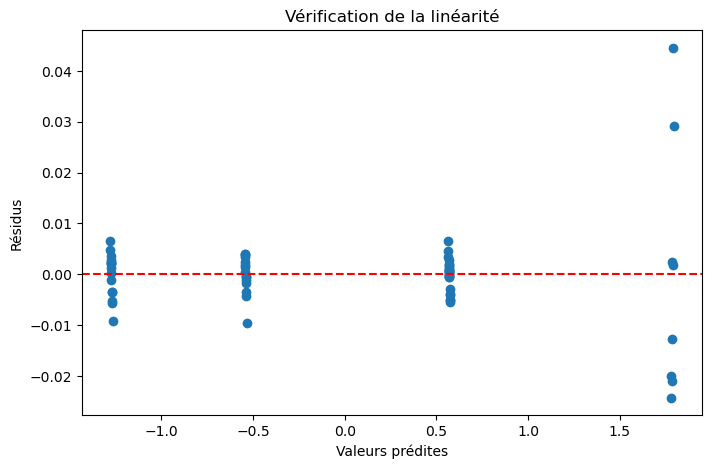

Statistique de Durbin-Watson : 2.0399 (proche de 2 = pas d'autocorrélation)
Test de Breusch-Pagan - p-value : 0.0001 (p>0.05 = homoscédasticité)

Tests de normalité des résidus :
Shapiro-Wilk p-value : 0.0000 (p>0.05 = normalité)
Kolmogorov-Smirnov p-value : 0.0011 (p>0.05 = normalité)

Vérification de la multicolinéarité :
                           Variable        VIF
0                             const  13.035777
1                        Engagement   1.200579
2               Yearly_PayScale_Yen   1.929583
3      Source_of_Hire_Career_Portal   2.450091
4  Source_of_Hire_Employee_Referral   4.107287
5         Source_of_Hire_Job_Boards   3.151325
6           Source_of_Hire_LinkedIn   3.277001


In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Test de linéarité (nuage de points des résidus)
plt.figure(figsize=(8, 5))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Vérification de la linéarité")
plt.show()

# 2. Test d'indépendance des erreurs (Durbin-Watson)
dw_stat = durbin_watson(model.resid)
print(f"Statistique de Durbin-Watson : {dw_stat:.4f} (proche de 2 = pas d'autocorrélation)")

# 3. Test d'homoscedasticité (Breusch-Pagan)
bp_test = het_breuschpagan(model.resid, X)
print(f"Test de Breusch-Pagan - p-value : {bp_test[1]:.4f} (p>0.05 = homoscédasticité)")

# 4. Test de normalité des résidus
print("\nTests de normalité des résidus :")

# Shapiro-Wilk Test
shapiro_test = shapiro(model.resid)
print(f"Shapiro-Wilk p-value : {shapiro_test.pvalue:.4f} (p>0.05 = normalité)")

# Kolmogorov-Smirnov Test
ks_test = kstest(model.resid, 'norm', args=(np.mean(model.resid), np.std(model.resid)))
print(f"Kolmogorov-Smirnov p-value : {ks_test.pvalue:.4f} (p>0.05 = normalité)")

# 5. Test de multicolinéarité (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVérification de la multicolinéarité :")
print(vif_data)


**1 . Autocorrélation des résidus (Durbin-Watson)** :
- valeur proche de 2 indique pas de corrélation des résidus. 

**2 . Homoscedasticité (Breusch - Pagan)** :
- p-value= 0
- présence hétéroscédasticité 
- Cela peut être dû à la structure des variables catégorielles et à un éventuel déséquilibre dans les groupes (certaines modalités ayant beaucoup plus d’observations que d’autres)

**3 . Normalité des résidus** :
- Shapiro-Wilk p-value : 0
- Kolmogorov-Smirnov p-value : 0.0011
- rejet de hypothése de normalité des résidues. 
- Avec des variables catégorielles, la normalité des résidus n'est pas une hypothèse essentielle, surtout si ton échantillon est grand (le théorème central limite aide).

**4 . Multicolinéarité (VIF)** :
- Aucun probléme de multicolinéarité

**Méthode de correction robuste pour la covariance, afin de corriger les erreurs types de ton modèle de régression.**

In [38]:
model_white = model.get_robustcov_results(cov_type="HC0")
print(model_white.summary())
# Récupérer les résultats
bp_stat = bp_test[0]  # Statistique du test
bp_p_value = bp_test[1]  # p-value du test

print(f"Statistique de Breusch-Pagan : {bp_stat:.4f}")
print(f"P-value : {bp_p_value:.4f}")

# Interprétation
if bp_p_value < 0.05:
    print(" Il y a de l'hétéroscédasticité (on rejette l'hypothèse d'homoscédasticité).")
else:
    print(" Pas d'hétéroscédasticité détectée (on accepte l'hypothèse d'homoscédasticité).")

                            OLS Regression Results                            
Dep. Variable:           Cost_of_Hire   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.554e+04
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           6.54e-87
Time:                        04:14:59   Log-Likelihood:                 206.14
No. Observations:                  64   AIC:                            -402.3
Df Residuals:                      59   BIC:                            -391.5
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

c:\Users\ghali\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '


méthode ne fonctionne pas

In [ ]:

##### TIME_TO_HIRE_DAYS ########
#####MODELE FAIT PAR LES TESTS#####
import statsmodels.api as sm

X = df_standardized[['PerformanceScore','Department_Production', 'Job_Title_Production_Technician_I', 'Job_Title_Sr_Network_Engineer', 'Quarter']]
y = df_standardized['Time_to_Hire_Days']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Time_to_Hire_Days   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     2.403
Date:                Wed, 05 Mar 2025   Prob (F-statistic):             0.0476
Time:                        04:14:59   Log-Likelihood:                -84.786
No. Observations:                  64   AIC:                             181.6
Df Residuals:                      58   BIC:                             194.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Le modéle n'est pas bon, R-sqaured trop bas, avec une F-Statistic pas bonne et AIC et BIC aussi pas bon

**BON MODELE POUR Time_to_Hire_Days**

In [ ]:
##BON MODELE####

import statsmodels.api as sm

X = df_standardized[['Yearly_PayScale_Yen', 'Quarter', 'Source_of_Hire_LinkedIn', 'PerformanceScore','Ramp_Up_Time']]

y = df_standardized['Time_to_Hire_Days']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Time_to_Hire_Days   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     3.107
Date:                Wed, 05 Mar 2025   Prob (F-statistic):             0.0149
Time:                        04:14:59   Log-Likelihood:                -83.217
No. Observations:                  64   AIC:                             178.4
Df Residuals:                      58   BIC:                             191.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

meilleur R-Squared, AIC et BIC et F-Stat.

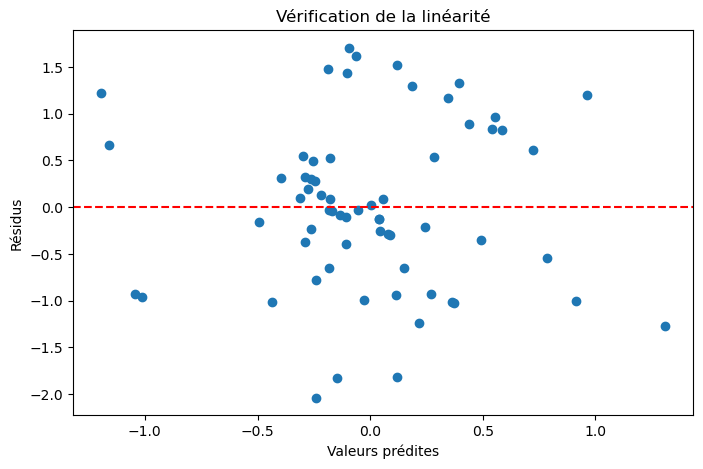

Statistique de Durbin-Watson : 2.0993 (proche de 2 = pas d'autocorrélation)
Test de Breusch-Pagan - p-value : 0.4363 (p>0.05 = homoscédasticité)

Tests de normalité des résidus :
Shapiro-Wilk p-value : 0.3800 (p>0.05 = normalité)
Kolmogorov-Smirnov p-value : 0.8868 (p>0.05 = normalité)

Vérification de la multicolinéarité :
                  Variable        VIF
0                    const  16.729731
1      Yearly_PayScale_Yen   1.462877
2                  Quarter   1.460452
3  Source_of_Hire_LinkedIn   1.074189
4         PerformanceScore   1.076393
5             Ramp_Up_Time   1.035780


In [41]:

# 1. Test de linéarité (nuage de points des résidus)
plt.figure(figsize=(8, 5))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Vérification de la linéarité")
plt.show()

# 2. Test d'indépendance des erreurs (Durbin-Watson)
dw_stat = durbin_watson(model.resid)
print(f"Statistique de Durbin-Watson : {dw_stat:.4f} (proche de 2 = pas d'autocorrélation)")

# 3. Test d'homoscedasticité (Breusch-Pagan)
bp_test = het_breuschpagan(model.resid, X)
print(f"Test de Breusch-Pagan - p-value : {bp_test[1]:.4f} (p>0.05 = homoscédasticité)")

# 4. Test de normalité des résidus
print("\nTests de normalité des résidus :")

# Shapiro-Wilk Test
shapiro_test = shapiro(model.resid)
print(f"Shapiro-Wilk p-value : {shapiro_test.pvalue:.4f} (p>0.05 = normalité)")

# Kolmogorov-Smirnov Test
ks_test = kstest(model.resid, 'norm', args=(np.mean(model.resid), np.std(model.resid)))
print(f"Kolmogorov-Smirnov p-value : {ks_test.pvalue:.4f} (p>0.05 = normalité)")

# 5. Test de multicolinéarité (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVérification de la multicolinéarité :")
print(vif_data)


- Pas de problème d'autocorrélation des erreurs.
- Pas d'hétéroscédasticité (les erreurs ont une variance constante).
- Les résidus suivent une distribution normale (ce qui est bien pour les tests de significativité).
- Pas de multicolinéarité (les variables explicatives sont indépendantes entre elles).

In [ ]:
####modele pour Time_to_Hire_Days#####
import statsmodels.api as sm

X = df_standardized[['Yearly_PayScale_Yen','PerformanceScore', 'Quarter','Job_Title_Sr_Network_Engineer']]

y = df_standardized['Time_to_Hire_Days']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Time_to_Hire_Days   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     3.466
Date:                Wed, 05 Mar 2025   Prob (F-statistic):             0.0131
Time:                        04:14:59   Log-Likelihood:                -84.058
No. Observations:                  64   AIC:                             178.1
Df Residuals:                      59   BIC:                             188.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

**TEST DE MODELE AVEC INTERACTION**

- Job_Title_Production_Manager : il existe une différence significative dans le temps de recrutement pour le département production par rapport aux autres départements.
- Job_Title_Production_Technician_I : une différence significative pour ce titre de poste par rapport aux autres.
- Job_Title_Sr_Network_Engineer : il existe une différence pour ce titre de poste par rapport aux autres.
- C(Department_Production):C(Job_Title_Production_Manager) (pvalue :0.029302)
- C(Department_Production):C(Job_Title_Production_Technician_I) (pvalue:0.029412) 
- C(Department_Sales):C(Source_of_Hire_Job_Boards) (pvalue:0.000044) 
- C(Department_Sales):C(PerformanceScore)  (pvalue: 0.000318)  
- C(Department_Sales):C(Sex)  (pvalue :0.049636)
- Job_Title_Sr_Sales_Engineer) : C(Source_of_Hire_Job_Boards) (pvalue:0.000044)  
- C(Job_Title_Sr_Sales_Engineer):C(PerformanceScore) (pvalue:0.000318)
- C(Job_Title_Sr_Sales_Engineer):C(Sex)  (pvalue :0.049636)  

In [43]:
df_standardized.columns

Index(['Quarter', 'PerformanceScore', 'Sex', 'Yearly_PayScale_Yen',
       'Ramp_Up_Time', 'Cost_of_Hire', 'Time_to_Hire_Days', 'Quality_of_Hire',
       'Engagement', 'Culture_Fit_', 'Department_Marketing',
       'Department_Production', 'Department_Sales',
       'Job_Title_Marketing_Analyst', 'Job_Title_Production_Manager',
       'Job_Title_Production_Technician_I', 'Job_Title_Software_Engineer',
       'Job_Title_Sr_Network_Engineer', 'Job_Title_Sr_Sales_Engineer',
       'Source_of_Hire_Career_Portal', 'Source_of_Hire_Employee_Referral',
       'Source_of_Hire_Job_Boards', 'Source_of_Hire_LinkedIn',
       'Type_of_Hire_Internal'],
      dtype='object')

In [ ]:
import pandas as pd
import statsmodels.api as sm

df_standardized["Department_Production:Job_Title_Production_Manager"] = df_standardized["Department_Production"] * df_standardized["Job_Title_Production_Manager"]
df_standardized["Department_Production:Job_Title_Production_Technician_I"] = df_standardized["Department_Production"] * df_standardized["Job_Title_Production_Technician_I"]
df_standardized["Department_Production:Source_of_Hire_Job_Boards"] = df_standardized["Department_Sales"] * df_standardized["Source_of_Hire_Job_Boards"]
df_standardized["Department_Sales:PerformanceScore"] = df_standardized["Department_Sales"] * df_standardized["PerformanceScore"]
df_standardized["Department_Sales:Sex"] = df_standardized["Department_Sales"] * df_standardized["Sex"]
df_standardized["Job_Title_Sr_Sales_Engineer:Source_of_Hire_Job_Boards"] = df_standardized["Job_Title_Sr_Sales_Engineer"] * df_standardized["Source_of_Hire_Job_Boards"]
df_standardized["Job_Title_Sr_Sales_Engineer:PerformanceScore"] = df_standardized["Job_Title_Sr_Sales_Engineer"] * df_standardized["PerformanceScore"]
df_standardized["Job_Title_Sr_Sales_Engineer:Sex"] = df_standardized["Job_Title_Sr_Sales_Engineer"] * df_standardized["Sex"]

df_selected = df_standardized[
    [
        "Time_to_Hire_Days",
        "PerformanceScore",
        "Culture_Fit_",
        "Quarter",
        "Ramp_Up_Time",
        "Job_Title_Sr_Network_Engineer", "Department_Production:Job_Title_Production_Manager",'Department_Production:Job_Title_Production_Technician_I',
        'Department_Production:Source_of_Hire_Job_Boards',
        "Department_Sales:PerformanceScore",
        "Department_Sales:Sex",
        "Job_Title_Sr_Sales_Engineer:Source_of_Hire_Job_Boards",
        "Job_Title_Sr_Sales_Engineer:PerformanceScore",
        "Job_Title_Sr_Sales_Engineer:Sex",
    ]
].copy()

Y = df_standardized["Time_to_Hire_Days"]
X = df_selected.drop(columns=["Time_to_Hire_Days"])  # Supprimer Y des prédicteurs

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Time_to_Hire_Days   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     1.745
Date:                Wed, 05 Mar 2025   Prob (F-statistic):             0.0947
Time:                        04:14:59   Log-Likelihood:                -81.704
No. Observations:                  64   AIC:                             185.4
Df Residuals:                      53   BIC:                             209.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

p-value des interactions non significative

**Pour Quality_of_Hire les variables significatifs** : 
- Culture_Fit_ (p-value: 0.014)
- Department_Sales (p-value: 0.042)   
- Job_Title_Sr_Sales_Engineer (p-value: 0.042)    
- PerformanceScore (p-valu: 0.062)     
- Quarter (p-value :0.000)   
- Ramp_Up_Time (p-value :0.002)     
- Yearly_PayScale_Yen (p-value :0.040) 

   - Quality of Hire pour variables quantitatives:
     - Très corrélée avec "Culture Fit (%)" (0.73) et "Engagement" (0.84) et Quarter (0.91) ce qui suggère que ces variables influencent fortement la qualité des recrutements.


In [45]:
##### Quality_of_Hire ########
import statsmodels.api as sm

X = df_standardized[[ 'Culture_Fit_', 'Department_Sales','Yearly_PayScale_Yen','Quarter', 'Job_Title_Sr_Sales_Engineer', 'PerformanceScore', 'Ramp_Up_Time']]
y = df_standardized['Quality_of_Hire']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Quality_of_Hire   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     78.03
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.18e-25
Time:                        04:14:59   Log-Likelihood:                -19.750
No. Observations:                  64   AIC:                             53.50
Df Residuals:                      57   BIC:                             68.61
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
##### Quality_of_Hire ajout de engagement car très corrélé à la varibale quality_to_hire########
import statsmodels.api as sm

X = df_standardized[[ 'Culture_Fit_', 'Engagement', 'Department_Sales','Yearly_PayScale_Yen','Quarter', 'Job_Title_Sr_Sales_Engineer', 'PerformanceScore', 'Ramp_Up_Time']]
y = df_standardized['Quality_of_Hire']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Quality_of_Hire   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     65.72
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.09e-24
Time:                        04:14:59   Log-Likelihood:                -19.745
No. Observations:                  64   AIC:                             55.49
Df Residuals:                      56   BIC:                             72.76
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

**Pour Quality_of_Hire les variables significatifs** : 
- Culture_Fit_  (p-value: 0.014)
- Department_Sales    (p-value: 0.042)   
- Job_Title_Sr_Sales_Engineer  (p-value: 0.042)    
- PerformanceScore   (p-valu: 0.062)     
- Quarter    (p-value :0.000)   
- Ramp_Up_Time    (p-value :0.002)     
- Yearly_PayScale_Yen  (p-value :0.040) 


In [ ]:
##### Quality_of_Hire ON SELECIONNE CE MODELE########
import statsmodels.api as sm

X = df_standardized[['Culture_Fit_','Yearly_PayScale_Yen','Quarter', 'Job_Title_Sr_Sales_Engineer', 'Ramp_Up_Time']]
y = df_standardized['Quality_of_Hire']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Quality_of_Hire   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     91.93
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           2.85e-26
Time:                        01:47:20   Log-Likelihood:                -20.769
No. Observations:                  64   AIC:                             53.54
Df Residuals:                      58   BIC:                             66.49
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

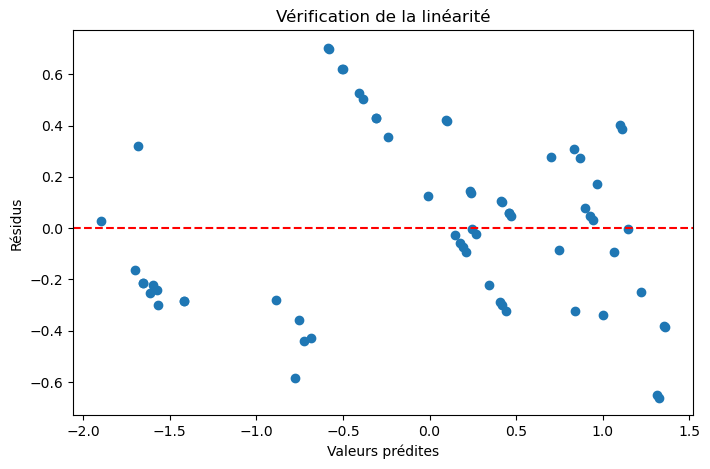

Statistique de Durbin-Watson : 0.8740 (proche de 2 = pas d'autocorrélation)
Test de Breusch-Pagan - p-value : 0.0910 (p>0.05 = homoscédasticité)

Tests de normalité des résidus :
Shapiro-Wilk p-value : 0.1525 (p>0.05 = normalité)
Kolmogorov-Smirnov p-value : 0.3635 (p>0.05 = normalité)

Vérification de la multicolinéarité :
                      Variable       VIF
0                        const  1.072284
1                 Culture_Fit_  2.274742
2          Yearly_PayScale_Yen  1.473270
3                      Quarter  1.664350
4  Job_Title_Sr_Sales_Engineer  1.084260
5                 Ramp_Up_Time  2.259914


In [60]:

# 1. Test de linéarité (nuage de points des résidus)
plt.figure(figsize=(8, 5))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Vérification de la linéarité")
plt.show()

# 2. Test d'indépendance des erreurs (Durbin-Watson)
dw_stat = durbin_watson(model.resid)
print(f"Statistique de Durbin-Watson : {dw_stat:.4f} (proche de 2 = pas d'autocorrélation)")

# 3. Test d'homoscedasticité (Breusch-Pagan)
bp_test = het_breuschpagan(model.resid, X)
print(f"Test de Breusch-Pagan - p-value : {bp_test[1]:.4f} (p>0.05 = homoscédasticité)")

# 4. Test de normalité des résidus
print("\nTests de normalité des résidus :")

# Shapiro-Wilk Test
shapiro_test = shapiro(model.resid)
print(f"Shapiro-Wilk p-value : {shapiro_test.pvalue:.4f} (p>0.05 = normalité)")

# Kolmogorov-Smirnov Test
ks_test = kstest(model.resid, 'norm', args=(np.mean(model.resid), np.std(model.resid)))
print(f"Kolmogorov-Smirnov p-value : {ks_test.pvalue:.4f} (p>0.05 = normalité)")

# 5. Test de multicolinéarité (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVérification de la multicolinéarité :")
print(vif_data)

**BON MODELE POUR Quality_of_Hire**

In [ ]:
##### Quality_of_Hire ON SELECIONNE CE MODELE########
import statsmodels.api as sm

X = df_standardized[['Culture_Fit_', 'Yearly_PayScale_Yen','Quarter', 'Job_Title_Sr_Sales_Engineer', 'Ramp_Up_Time']]
y = df_standardized['Quality_of_Hire']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Quality_of_Hire   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     76.94
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.67e-25
Time:                        04:20:55   Log-Likelihood:                -20.150
No. Observations:                  64   AIC:                             54.30
Df Residuals:                      57   BIC:                             69.41
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

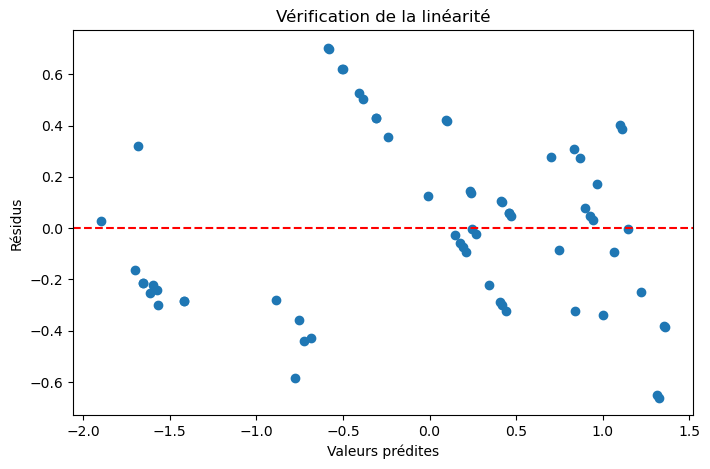

Statistique de Durbin-Watson : 0.8740 (proche de 2 = pas d'autocorrélation)
Test de Breusch-Pagan - p-value : 0.0910 (p>0.05 = homoscédasticité)

Tests de normalité des résidus :
Shapiro-Wilk p-value : 0.1525 (p>0.05 = normalité)
Kolmogorov-Smirnov p-value : 0.3635 (p>0.05 = normalité)

Vérification de la multicolinéarité :
                      Variable       VIF
0                        const  1.072284
1                 Culture_Fit_  2.274742
2          Yearly_PayScale_Yen  1.473270
3                      Quarter  1.664350
4  Job_Title_Sr_Sales_Engineer  1.084260
5                 Ramp_Up_Time  2.259914


In [50]:

# 1. Test de linéarité (nuage de points des résidus)
plt.figure(figsize=(8, 5))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Vérification de la linéarité")
plt.show()

# 2. Test d'indépendance des erreurs (Durbin-Watson)
dw_stat = durbin_watson(model.resid)
print(f"Statistique de Durbin-Watson : {dw_stat:.4f} (proche de 2 = pas d'autocorrélation)")

# 3. Test d'homoscedasticité (Breusch-Pagan)
bp_test = het_breuschpagan(model.resid, X)
print(f"Test de Breusch-Pagan - p-value : {bp_test[1]:.4f} (p>0.05 = homoscédasticité)")

# 4. Test de normalité des résidus
print("\nTests de normalité des résidus :")

# Shapiro-Wilk Test
shapiro_test = shapiro(model.resid)
print(f"Shapiro-Wilk p-value : {shapiro_test.pvalue:.4f} (p>0.05 = normalité)")

# Kolmogorov-Smirnov Test
ks_test = kstest(model.resid, 'norm', args=(np.mean(model.resid), np.std(model.resid)))
print(f"Kolmogorov-Smirnov p-value : {ks_test.pvalue:.4f} (p>0.05 = normalité)")

# 5. Test de multicolinéarité (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVérification de la multicolinéarité :")
print(vif_data)

- pas d'autocorrélation (Durbin-Watson proche de 2).
- Homoscédasticité (Breusch-Pagan p-value > 0.05).
- Normalité des résidus (Shapiro-Wilk et Kolmogorov-Smirnov p-values > 0.05).
- Pas de problème majeur de multicolinéarité (VIF < 5 pour toutes les variables).



In [ ]:
X = df_standardized[['Culture_Fit_', 'Engagement', 'Quarter', 'Job_Title_Marketing_Analyst',
                     'Department_Marketing', 'Source_of_Hire_Employee_Referral', 'Department_Production',
                     'Source_of_Hire_LinkedIn', 'Type_of_Hire_Internal']]

X['Department_Marketing * Source_of_Hire_Employee_Referral'] = X['Department_Marketing'] * X['Source_of_Hire_Employee_Referral']
X['Department_Production * Source_of_Hire_Employee_Referral'] = X['Department_Production'] * X['Source_of_Hire_Employee_Referral']
X['Department_Production * Source_of_Hire_LinkedIn'] = X['Department_Production'] * X['Source_of_Hire_LinkedIn']
X['Department_Production * Type_of_Hire_Internal'] = X['Department_Production'] * X['Type_of_Hire_Internal']

X = sm.add_constant(X)

y = df_standardized['Quality_of_Hire']

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        Quality_of_Hire   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     34.81
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           8.67e-20
Time:                        04:15:00   Log-Likelihood:                -26.045
No. Observations:                  64   AIC:                             74.09
Df Residuals:                      53   BIC:                             97.84
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

C:\Users\ghali\AppData\Local\Temp\ipykernel_20188\1593869076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Department_Marketing * Source_of_Hire_Employee_Referral'] = X['Department_Marketing'] * X['Source_of_Hire_Employee_Referral']
C:\Users\ghali\AppData\Local\Temp\ipykernel_20188\1593869076.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Department_Production * Source_of_Hire_Employee_Referral'] = X['Department_Production'] * X['Source_of_Hire_Employee_Referral']
C:\Users\ghali\AppData\Loc

p-value des variables interactions sont non significative